# 1. Bibliotecas e parâmetros utilizados

In [ ]:
# !pip install numpy pandas matplotlib seaborn plotly opencv-python psutil

In [1]:
import os
import time
import psutil  
import pickle
import glob

import numpy as np
import pandas as pd
import pygad

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import seaborn as sns
import plotly.graph_objects as go
import cv2

In [2]:
os.makedirs("logs", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("frames", exist_ok=True)
os.makedirs(pop_dir, exist_ok=True)

logs_dir = "logs"
results_dir = "results"
frames_dir = "frames"
pop_dir = "pop_frames"

In [10]:
# Domínio da função:
x_min, x_max = -100, 100
y_min, y_max = x_min, x_max

# Parâmetros:
GENE_SPACE = [0, 1]           # Espaço dos genes (binário)
precision = 5                 # quantidade de casas decimais
n_bits =  int(np.ceil(np.log2(
    (x_max-x_min) * np.power(10,precision))))  # número de bits: 25
GENOME_LENGHT = 2 * n_bits    # comprimento do genoma completo para X e Y
POP_SIZE = 500                # tamanho da população inicial
N_GEN = 500                   # número de gerações do algoritmo
N_RUNS = 32                   # número de experimentos 
CROSSOVER_RATE = 0.8          # taxa de cruzamento: 80%
MUTATION_RATE = 0.01          # taxa de mutação: 1%
ELITISM = 1                   # indiviuos salvos por elitismo em cada geração 
SELECTION = "rws"             # método de seleção de cruzamento: roleta
MUTATION = "random"           # método de mutação: aleatório
CROSSOVER = "single_point"    # método de cruzamento: um ponto de corte

LOG_INTERVAL = 50             # intervalo para salvar dados de execução
SAVE_INTERVAL = 10            # Intervalo de frames para o GIF

In [4]:
# Função Shaffer Nº 2 (F6):
def f6(x, y):
    num = np.sin(np.sqrt(x**2 + y**2))**2 - 0.5
    denom = (1 + 0.001 * (x**2 + y**2))**2
    return 0.5 - num / denom

In [5]:
# Conversão binária → float
def binary_to_float(binary_array, domain_min, domain_max):
    integer_value = int("".join(str(int(b)) for b in binary_array), 2)
    scale = (domain_max - domain_min) / (2**len(binary_array) - 1)
    return domain_min + integer_value * scale

In [6]:
# Decodificar cromossomo
def decode_solution(solution):
    x_bin = solution[:n_bits]
    y_bin = solution[n_bits:]
    x = binary_to_float(x_bin, x_min, x_max)
    y = binary_to_float(y_bin, y_min, y_max)
    return x, y

# 2. Visualização do espaço real da função

In [ ]:
# Visualização:
x_minv, x_maxv = -10, 10
y_minv, y_maxv = x_minv, x_maxv

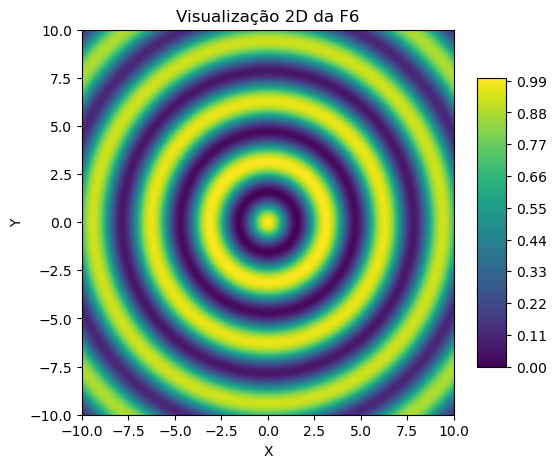

In [41]:
X, Y = np.meshgrid(np.linspace(-10, 10, 400), np.linspace(-10, 10, 400))
Z = f6(X, Y)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
surf = ax.contourf(X, Y, Z, levels=100, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Visualização 2D da F6')

# Barra de cores
fig.colorbar(surf, shrink=0.75, aspect=10)

plt.savefig(f"{results_dir}/F6_2D_space.png")
plt.show()

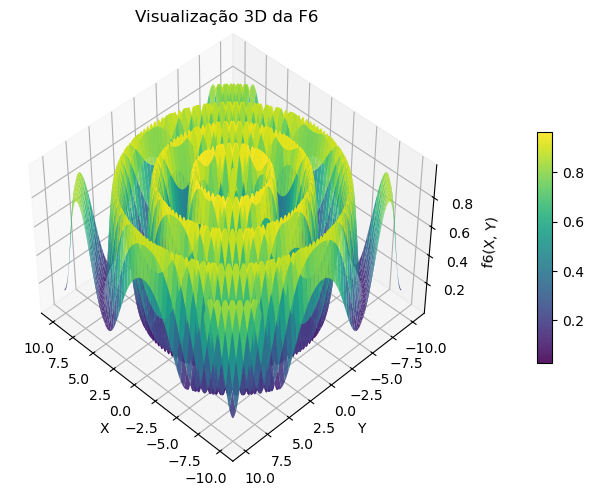

In [42]:
# Geração da malha
X, Y = np.meshgrid(np.linspace(-10, 10, 400), np.linspace(-10, 10, 400))
Z = f6(X, Y)  # Sua função objetivo

# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Superfície 3D
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

# Vista diagonal (ângulos de elevação e azimute)
ax.view_init(elev=45, azim=135)

# Rótulos
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f6(X, Y)')
ax.set_title('Visualização 3D da F6')

# Barra de cores
fig.colorbar(surf, shrink=0.5, aspect=15, pad=0.15)

# Salvar e mostrar
plt.savefig(f"{results_dir}/F6_3D_space.png")
plt.show()

# 3. Execução do algoritmo genético com pygad

In [7]:
# Função de aptidão customizada:
def fitness_function_custom(ga_instance, solution, solution_idx):
    global fitness_calls, fitness_time_total
    start_time = time.time()

    x, y = decode_solution(solution)  
    fitness = f6(x, y)   

    fitness_calls += 1
    fitness_time_total += time.time() - start_time

    return fitness

In [15]:
# Função customizada par salvar resultados da geração
def on_generation_custom(ga_instance):
    gen = ga_instance.generations_completed
    if gen == 1 or gen % LOG_INTERVAL == 0: # Para número de gerações
        fitness_values = ga_instance.last_generation_fitness
        min_fit = np.min(fitness_values)
        mean_fit = np.mean(fitness_values)
        max_fit = np.max(fitness_values)

        # Uso de recursos
        cpu_percent = psutil.cpu_percent(interval=None)
        mem_info = psutil.virtual_memory().used / (1024 ** 2)  # MB

        generation_logs.append({
                "run": run + 1,
                "generation": gen,
                "min_fitness": min_fit,
                "mean_fitness": mean_fit,
                "max_fitness": max_fit,
                "fitness_calls": fitness_calls,
                "fitness_time_total": fitness_time_total,
                "avg_time_per_gen": (time.time() - run_start) / (gen + 1),
                "cpu_percent": cpu_percent,
                "memory_used_MB": mem_info,
        })

        print(f"Geração {gen:03}: min={min_fit:.5f}, média={mean_fit:.5f}, max={max_fit:.5f}" 
            + f" | CPU: {cpu_percent:.1f}% | RAM: {mem_info:.1f} MB")

In [16]:
# Armazenar resultados
all_runs_fitness = []
best_attempt = {}

# iniciar tempo de execução total:
global_start = time.time()

# Execução
for run in range(N_RUNS):
    
    print(f"\n🧪 Iniciando Execução {run+1}/{N_RUNS}")
    run_start = time.time() # Iniciar tempo do experimento
    generation_logs = []

    fitness_calls = 0
    fitness_time_total = 0.0


    ga = pygad.GA(
        num_generations= N_GEN,
        num_parents_mating= int(POP_SIZE * CROSSOVER_RATE), 
        fitness_func = fitness_function_custom,
        sol_per_pop = POP_SIZE, 
        num_genes = GENOME_LENGHT,
        gene_space = GENE_SPACE,
        parent_selection_type = SELECTION,
        crossover_type = CROSSOVER,
        mutation_type = MUTATION,
        keep_elitism = ELITISM,
        mutation_percent_genes = int(MUTATION_RATE * 100),
        on_generation = on_generation_custom,
        save_best_solutions = True
    )

    ga.run()
    
    fitness_history = ga.best_solutions_fitness
    all_runs_fitness.append(fitness_history)

    # Salva a execução com maior aptidão até o momento:
    if not best_attempt or max(fitness_history) > max(best_attempt["fitness"]):
        best_attempt = {
            "ga": ga,
            "fitness": fitness_history
        }

    run_time = time.time() - run_start       # tempo do experimento
    total_time = time.time() - global_start  # tempo total

    print(f"⏱️ Tempo da execução {run+1}: {run_time:.2f} segundos")
    print(f"⏳ Tempo acumulado: {total_time:.2f} segundos")
    print(f"✅ Finalizada Execução {run+1}/{N_RUNS} — Melhor fitness: {max(fitness_history):.5f}")

    for row in generation_logs:
        row["run_time_seconds"] = run_time
        row["total_time_seconds"] = total_time
        row["total_fitness_calls"] = fitness_calls
        row["total_fitness_eval_time"] = fitness_time_total

    # salvar log de cada execução
    df = pd.DataFrame(generation_logs)
    df.to_csv(f"{logs_dir}/execucao_{run+1:02}.csv", index=False)


🧪 Iniciando Execução 1/32
Geração 001: min=0.11004, média=0.50058, max=0.82898 | CPU: 18.4% | RAM: 4288.2 MB
Geração 050: min=0.00276, média=0.54366, max=0.99989 | CPU: 33.1% | RAM: 4294.2 MB
Geração 100: min=0.02182, média=0.55914, max=1.00000 | CPU: 35.3% | RAM: 4278.9 MB
Geração 150: min=0.01069, média=0.61272, max=1.00000 | CPU: 49.5% | RAM: 4383.7 MB
Geração 200: min=0.00246, média=0.63305, max=1.00000 | CPU: 50.5% | RAM: 4665.1 MB
Geração 250: min=0.03440, média=0.63966, max=1.00000 | CPU: 53.7% | RAM: 4400.0 MB
Geração 300: min=0.02220, média=0.63691, max=1.00000 | CPU: 48.5% | RAM: 4357.2 MB
Geração 350: min=0.02155, média=0.66364, max=1.00000 | CPU: 32.7% | RAM: 4341.4 MB
Geração 400: min=0.03071, média=0.64695, max=1.00000 | CPU: 34.2% | RAM: 4329.6 MB
Geração 450: min=0.01832, média=0.66460, max=1.00000 | CPU: 32.5% | RAM: 4331.0 MB
Geração 500: min=0.04600, média=0.64213, max=1.00000 | CPU: 35.5% | RAM: 4332.1 MB
⏱️ Tempo da execução 1: 38.17 segundos
⏳ Tempo acumulado: 38

In [17]:
# Salvar a melhor execução completa (modelo + dados)
with open(f"{logs_dir}/melhor_execucao.pkl", "wb") as f:
    pickle.dump({
        "ga": best_attempt["ga"],
        "fitness_history": best_attempt["fitness"]
    }, f)

with open(f"{logs_dir}/fitness_histories.pkl", "wb") as f:
    pickle.dump(all_runs_fitness, f)

# 4. Carregando dados salvos de execução

In [18]:
with open(f"{logs_dir}/melhor_execucao.pkl", "rb") as f:
    best_run_data = pickle.load(f)

with open(f"{logs_dir}/fitness_histories.pkl", "rb") as f:
    all_runs_fitness_data = pickle.load(f)

ga_best = best_run_data["ga"]
all_runs_fitness = all_runs_fitness_data

In [37]:
all_runs_fitness

array([[0.76768652, 0.82898485, 0.90903594, ..., 1.        , 1.        ,
        1.        ],
       [0.79584983, 0.80453218, 0.80453218, ..., 1.        , 1.        ,
        1.        ],
       [0.85354762, 0.87491168, 0.88715093, ..., 0.99028409, 0.99028409,
        0.99028409],
       ...,
       [0.90114229, 0.90114229, 0.9880401 , ..., 0.99028409, 0.99028409,
        0.99028409],
       [0.72639279, 0.91402885, 0.91402885, ..., 0.99935093, 0.99935093,
        0.99935093],
       [0.87374807, 0.9125754 , 0.91514424, ..., 1.        , 1.        ,
        1.        ]])

In [36]:
csv_files = sorted(glob.glob(os.path.join(logs_dir, "execucao_*.csv")))

# Lista de DataFrames
dfs = [pd.read_csv(f) for f in csv_files]

# Unir todos em um único DataFrame
df_all = pd.concat(dfs, ignore_index=True)

# Visualizações

5. Animação da trajetória do melhor indivíduo

In [26]:
# Geração do grid para heatmap da função F6:
X, Y = np.meshgrid(np.linspace(x_minv, x_maxv, 400), np.linspace(y_minv, y_maxv, 400))
Z = f6(X, Y)

# Salvar frames com o melhor indivíduo
frames = []

max_idx = min(len(ga_best.best_solutions), N_GEN)

for gen in range(0, max_idx, SAVE_INTERVAL):
    sol = ga_best.best_solutions[gen]
    x, y = decode_solution(sol)

    plt.figure(figsize=(6,5))
    plt.contourf(X, Y, Z, levels=100, cmap='viridis')
    plt.colorbar(label='F6(x, y)')
    plt.plot(x, y, 'ro')
    plt.title(f"Geração {gen}")
    plt.xlabel('x')
    plt.ylabel('y')

    fname = f"{frames_dir}/frame_{gen:03}.png"
    plt.savefig(fname)
    plt.close()
    frames.append(fname)

In [27]:
# Ordenar e filtrar os arquivos .png
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(".png")])

# Garantir que há pelo menos um frame
assert frame_files, f"Nenhum frame encontrado em '{frames_dir}/'."

# Ler o primeiro frame para obter dimensões
frame_path = os.path.join(frames_dir, frame_files[0])
frame = cv2.imread(frame_path)
height, width, _ = frame.shape

# Criar VideoWriter com codec MP4
out = cv2.VideoWriter(f"{results_dir}/evolucao_melhor_individuo_elitismo.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height))

# Escrever cada frame no vídeo
for fname in frame_files:
    img = cv2.imread(os.path.join(frames_dir, fname))
    out.write(img)

out.release()

6. Visualização da população em binário

In [28]:
pop_matrix = np.array(ga_best.population)

plt.figure(figsize=(12,6))
sns.heatmap(pop_matrix, cmap="gray_r", cbar=False)
plt.title("População final (representação binária)")
plt.xlabel("Bits do gene")
plt.ylabel("Indivíduo")
plt.tight_layout()
plt.savefig(f"{results_dir}/final_population_binary_elitism.png")
plt.close()


In [ ]:
pop_array = np.array(ga_best.population)
np.save("population_gen.npy", pop_array)

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(pop_loaded, cmap='Greys', aspect='auto')
plt.title("População - Representação Binária")
plt.xlabel("Genes")
plt.ylabel("Indivíduos")
plt.tight_layout()
plt.savefig("pop_matrix.png")
plt.show()

7. Gráfico de convergência com média e desvio padrão

In [29]:
padded_runs = []
for run in all_runs_fitness:
    run = np.array(run)
    if len(run) < N_GEN:
        padded = np.pad(run, (0, N_GEN - len(run)), constant_values=run[-1])
    else:
        padded = run[:N_GEN]
    padded_runs.append(padded)

all_runs_fitness = np.array(padded_runs)

mean_fitness = np.mean(all_runs_fitness, axis=0)
std_fitness = np.std(all_runs_fitness, axis=0)

plt.figure(figsize=(10,6))
plt.plot(mean_fitness, label='Média da Fitness', color='blue')
plt.fill_between(range(N_GEN), mean_fitness - std_fitness, mean_fitness + std_fitness, alpha=0.3, color='gray', label='Desvio Padrão')
plt.xlabel('Geração')
plt.ylabel('Fitness')
plt.title('Convergência Média da Fitness em 32 Execuções')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{results_dir}/convergencia_fitness_elitism.png")
plt.close()


8. Visualização do Desempenho

In [30]:
# Agrupar por geração
grouped = df_all.groupby("generation")

# Calcular médias e desvios
df_stats = grouped.agg({
    "avg_time_per_gen": ["mean", "std"],
    "cpu_percent": ["mean", "std"],
    "memory_used_MB": ["mean", "std"],
}).reset_index()

# Renomear colunas
df_stats.columns = ["generation",
                    "avg_time_per_gen_mean", "avg_time_per_gen_std",
                    "cpu_percent_mean", "cpu_percent_std",
                    "memory_used_MB_mean", "memory_used_MB_std"]

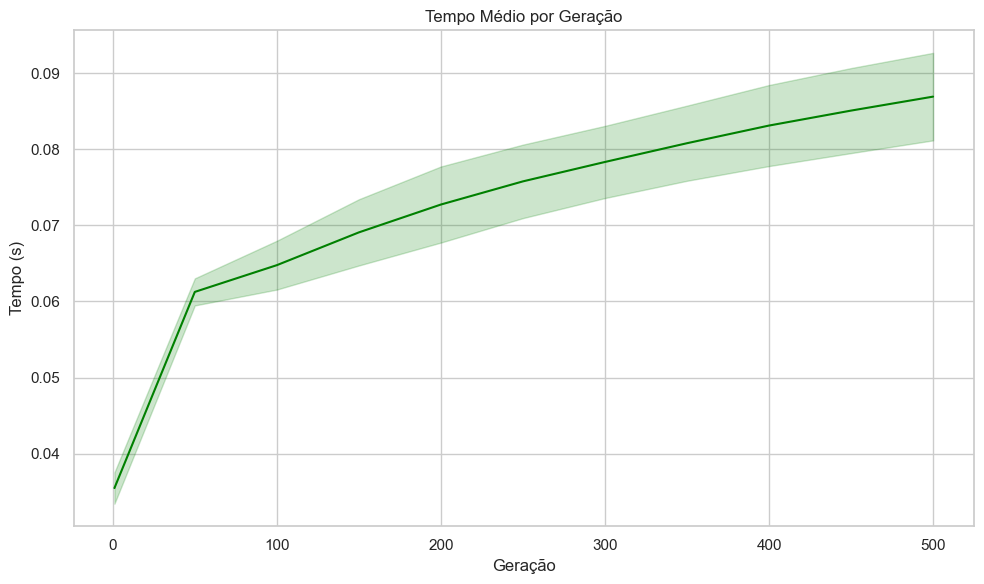

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(df_stats["generation"], df_stats["avg_time_per_gen_mean"], label="Tempo Médio", color="green")
plt.fill_between(df_stats["generation"],
                 df_stats["avg_time_per_gen_mean"] - df_stats["avg_time_per_gen_std"],
                 df_stats["avg_time_per_gen_mean"] + df_stats["avg_time_per_gen_std"],
                 color="green", alpha=0.2)
plt.title("Tempo Médio por Geração")
plt.xlabel("Geração")
plt.ylabel("Tempo (s)")

plt.tight_layout()
plt.savefig(f"{results_dir}/avg_time_per_gen_elitism.png", dpi=300)
plt.show()

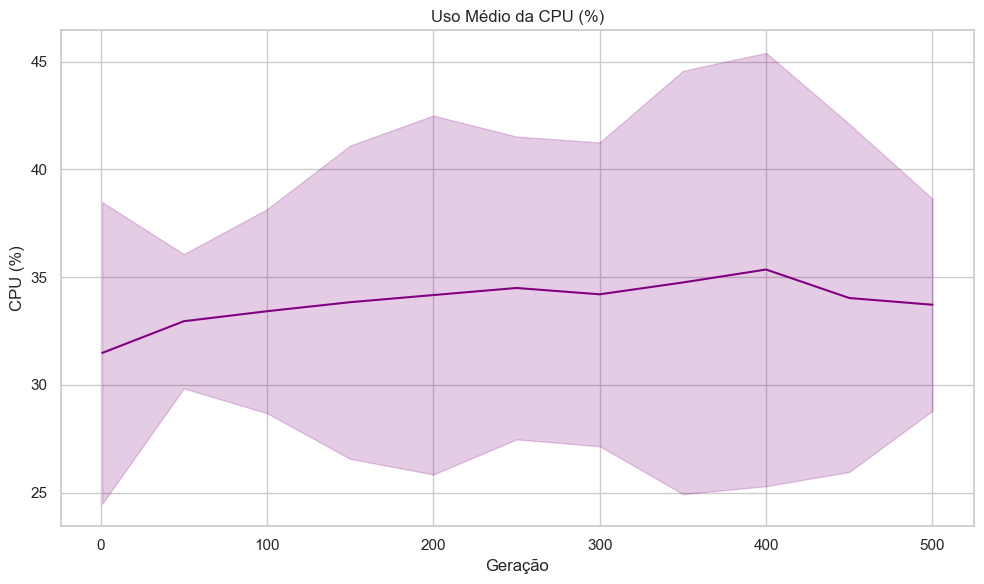

In [32]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(df_stats["generation"], df_stats["cpu_percent_mean"], label="Uso de CPU Médio", color="purple")
plt.fill_between(df_stats["generation"],
                 df_stats["cpu_percent_mean"] - df_stats["cpu_percent_std"],
                 df_stats["cpu_percent_mean"] + df_stats["cpu_percent_std"],
                 color="purple", alpha=0.2)
plt.title("Uso Médio da CPU (%)")
plt.xlabel("Geração")
plt.ylabel("CPU (%)")

plt.tight_layout()
plt.savefig(f"{results_dir}/avg_cpu_per_gen_elitism.png", dpi=300)
plt.show()

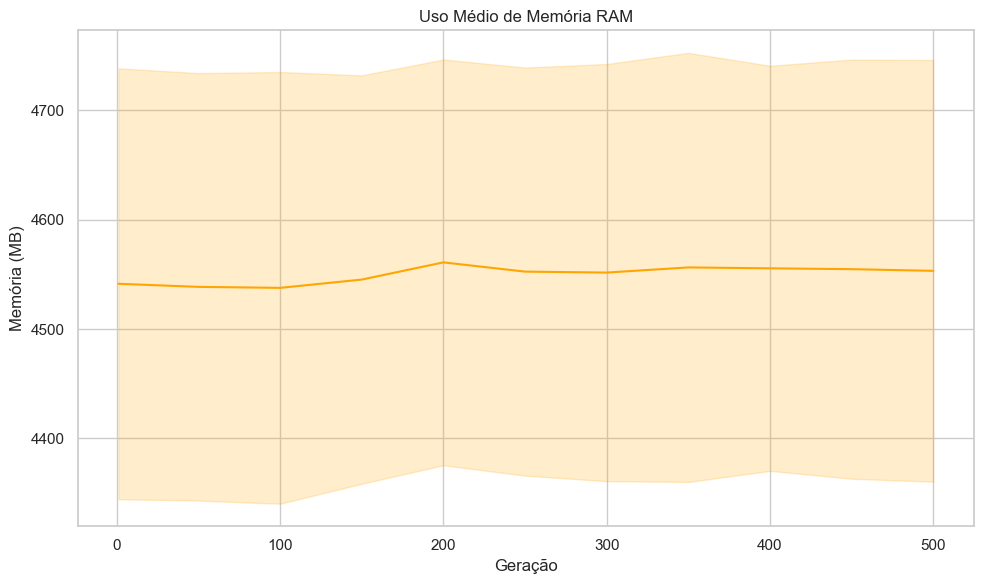

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(df_stats["generation"], df_stats["memory_used_MB_mean"], label="Uso de RAM Médio", color="orange")
plt.fill_between(df_stats["generation"],
                 df_stats["memory_used_MB_mean"] - df_stats["memory_used_MB_std"],
                 df_stats["memory_used_MB_mean"] + df_stats["memory_used_MB_std"],
                 color="orange", alpha=0.2)
plt.title("Uso Médio de Memória RAM")
plt.xlabel("Geração")
plt.ylabel("Memória (MB)")

plt.tight_layout()
plt.savefig(f"{results_dir}/avg_ram_per_gen_elitism.png", dpi=300)
plt.show()

# extra

Mapa interativo da posição do melhor individuo ao longo das gerações

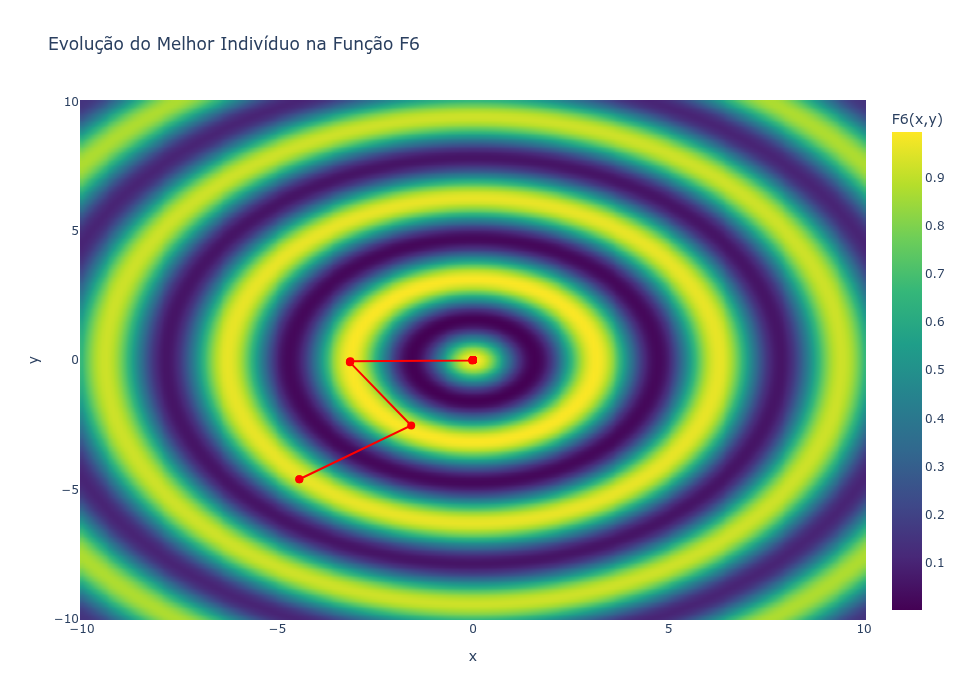

In [34]:
# Geração da malha
x_vals = np.linspace(x_minv, x_maxv, 200)
y_vals = np.linspace(y_minv, y_maxv, 200)
X, Y = np.meshgrid(x_vals, y_vals)
Z = f6(X, Y)

# Preparar coordenadas do melhor indivíduo a cada 10 gerações
traj_x, traj_y = [], []
for gen in range(0, N_GEN, SAVE_INTERVAL):
    sol = ga_best.best_solutions[gen]
    x, y = decode_solution(sol)
    traj_x.append(x)
    traj_y.append(y)

# Criar figura Plotly
fig = go.Figure()

# Heatmap de fundo
fig.add_trace(go.Heatmap(
    z=Z,
    x=x_vals,
    y=y_vals,
    colorscale='Viridis',
    colorbar=dict(title="F6(x,y)"),
    zsmooth="best"
))

# Linha da trajetória
fig.add_trace(go.Scatter(
    x=traj_x,
    y=traj_y,
    mode='markers+lines',
    marker=dict(color='red', size=8),
    name="Melhor indivíduo"
))

fig.update_layout(
    title="Evolução do Melhor Indivíduo na Função F6",
    xaxis_title="x",
    yaxis_title="y",
    width=800,
    height=700
)

fig.write_html(f"{results_dir}/melhor_ind_elitism_interativo.html")
fig.show()


Gráfico interativo da convergência ao longo das gerações

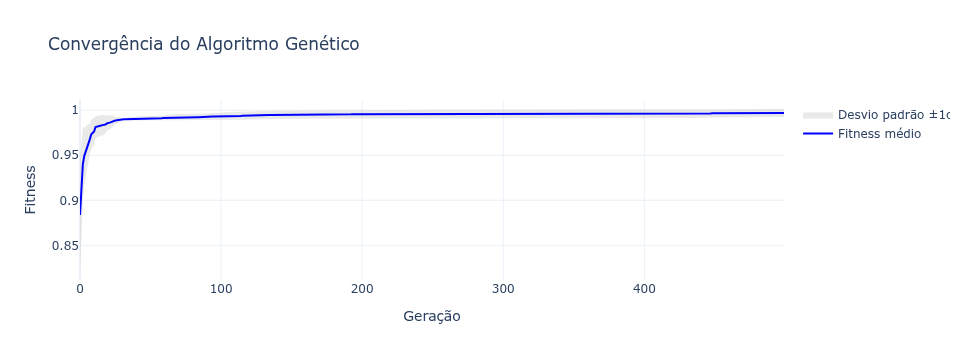

In [35]:
# Corrigir padding ou truncamento para garantir que todos tenham mesmo tamanho
padded_runs = []
for run in all_runs_fitness:
    run = np.array(run)
    if len(run) < N_GEN:
        padded = np.pad(run, (0, N_GEN - len(run)), constant_values=run[-1])
    else:
        padded = run[:N_GEN]
    padded_runs.append(padded)

# Matriz de shape (N_RUNS, N_GEN)
all_runs_fitness = np.array(padded_runs)

# Calcular estatísticas
mean_fitness = np.mean(all_runs_fitness, axis=0)
std_fitness = np.std(all_runs_fitness, axis=0)
generations = np.arange(N_GEN)

# Faixas para área sombreada
upper = mean_fitness + std_fitness
lower = mean_fitness - std_fitness

# Gráfico interativo
fig = go.Figure()

# Área sombreada do desvio padrão
fig.add_trace(go.Scatter(
    x=np.concatenate([generations, generations[::-1]]),
    y=np.concatenate([upper, lower[::-1]]),
    fill='toself',
    fillcolor='rgba(200,200,200,0.4)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='Desvio padrão ±1σ'
))

# Linha da média
fig.add_trace(go.Scatter(
    x=generations,
    y=mean_fitness,
    mode='lines',
    line=dict(color='blue', width=2),
    name='Fitness médio'
))

fig.update_layout(
    title="Convergência do Algoritmo Genético",
    xaxis_title="Geração",
    yaxis_title="Fitness",
    template="plotly_white",
    hovermode="x unified"
)

# Exibir ou salvar
fig.write_html(f"{results_dir}/convergencia_elitismo_interativo.html")
fig.show()